<a href="https://colab.research.google.com/github/Nukitt/chaii/blob/main/AQASH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

!pip install datasets transformers
import transformers

In [3]:

model_checkpoint = 'deepset/xlm-roberta-base-squad2'
batch_size = 4


In [4]:
from transformers import AutoTokenizer
!pip install sentencepiece    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
train = pd.read_csv('dataset/train.csv')
train['num_tokens_context'] = train['context'].apply(lambda t: len(tokenizer(t)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors


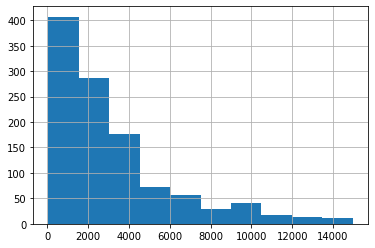

In [6]:
train['num_tokens_context'].hist()

In [7]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [8]:
pad_on_right = tokenizer.padding_side == "right"

In [9]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
!pip install Dataset
!pip uninstall fsspec -qq -y
!pip install --no-index --find-links hf-datasets/wheels datasets -qq
!pip install fsspec

In [11]:
from datasets import Dataset

In [12]:
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }

In [13]:
train = train.sample(frac=1, random_state=42)
train['answers'] = train[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

In [14]:
df_train = train[:-64].reset_index(drop=True)
df_valid = train[-64:].reset_index(drop=True)

In [15]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

In [16]:
train_dataset[0]

{'answer_start': 123,
 'answer_text': 'फ़िनक्स',
 'answers': {'answer_start': [123], 'text': ['फ़िनक्स']},
 'context': 'एरीजोना (English: Arizona) संयुक्त राज्य अमेरिका के दक्षिणपश्चिमी हिस्से में स्थित राज्य है। इसका सबसे बड़ा शहर और राजधानी फ़िनक्स है। दूसरा सबसे बड़ा राज्य टक्सन है और उसके बाद फ़िनक्स के महानगर क्षेत्र स्थित शहर मेसा, ग्लेनडेल, चंदलर और स्कोत्ट्सडेल है।\r\nएरीजोना संयुक्त राज्यों में शामिल होने वाला ४८व राज्य था जिसे की इसमें १४ फरबरी १९१२ को समिलित किया गया। इसी दिन इस राज्य की देश में माने जाने वाली भूमि की वर्षागाठ भी थी। एरीजोना अपने रेगिस्तानी मौसम, भयंकर गर्मी और हल्की ठंड के लिए जाना जाता है। पर राज्य के उच्च इलाकों में बहुत पहाड़ व जंगल है, इसी कारण वहाँ का मौसम अन्य राज्य के मुकाबले ठंडा रहता है। जुलाई १ २००६ के अनुसार एरीजोना देश में आबादी के हिसाब से सबसे तेजी से बढ़ता राज्य है। इससे पहले यह दर्जा नेवादा के पास था।\r\nराज्य का एक-चौथाई इलाका मूल अमेरिकी आदिवासी के लिये संरक्षित है। राज्य की आधिकरिक भाषा अँग्रेजी है जिसे बोलने वाले जनसंख्या के 74 प्रतिशत ह

In [17]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# New Section

In [18]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [19]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [20]:
args = TrainingArguments(
    f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
from transformers import default_data_collator

data_collator = default_data_collator

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [25]:
trainer.save_model("chaii-bert-trained")

Saving model checkpoint to chaii-bert-trained
Configuration saved in chaii-bert-trained/config.json
Model weights saved in chaii-bert-trained/pytorch_model.bin
tokenizer config file saved in chaii-bert-trained/tokenizer_config.json
Special tokens file saved in chaii-bert-trained/special_tokens_map.json


In [26]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [27]:
validation_features = valid_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=valid_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [28]:
len(validation_features)

816

In [29]:
validation_features

Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping'],
    num_rows: 816
})

In [30]:
valid_feats_small = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
valid_feats_small

  0%|          | 0/816 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 816
})

In [31]:
raw_predictions = trainer.predict(valid_feats_small)

***** Running Prediction *****
  Num examples = 816
  Batch size = 4


Epoch,Training Loss,Validation Loss


In [32]:
max_answer_length = 30

In [33]:
import collections

examples = valid_dataset
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [34]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        predictions[example["id"]] = best_answer["text"]

    return predictions

In [35]:
final_predictions = postprocess_qa_predictions(valid_dataset, validation_features, raw_predictions.predictions)

Post-processing 64 example predictions split into 816 features.


  0%|          | 0/64 [00:00<?, ?it/s]

In [36]:
references = [{"id": ex["id"], "answer": ex["answers"]['text'][0]} for ex in valid_dataset]

In [37]:
def jaccard(row): 
    str1 = row[0]
    str2 = row[1]
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [38]:
res = pd.DataFrame(references)
res['prediction'] = res['id'].apply(lambda r: final_predictions[r])
res['jaccard'] = res[['answer', 'prediction']].apply(jaccard, axis=1)
res

,id,answer,prediction,jaccard
0,dc64d02cf,प्रतिभा पाटील,डॉ॰गिरिजा व्यास,0.00
1,98d8542f6,பிங்க்,உட்,0.00
2,3ce81e663,मिर्ज़ा असद-उल्लाह बेग ख़ां,असद-उल्लाह बेग ख़ां,0.75
3,40f4e32da,मीटर प्रति सेकेण्ड2,सदिश,0.00
4,bfa4380bd,अगरतला,अगरतला,1.00
...,...,...,...,...
59,3acaa3b86,स्टेगेरिया,३८४-३२२ ई. पू.,0.00
60,7a3e4bf22,கி.மு 3000,ிலேயே,0.00
61,de34ee0a0,माइकोलैव ब्लैक ‍सी शिपयार्ड,आई एन एस विराट,0.00
62,518fc3aaf,तेरह,तेरह,1.00


In [39]:
res.jaccard.mean()

0.41666666666666663

In [42]:
test = pd.read_csv('dataset/test.csv')

In [43]:
test_dataset = Dataset.from_pandas(test)

In [44]:
test_features = test_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [45]:
test_feats_small = test_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
test_feats_small

  0%|          | 0/67 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 67
})

In [46]:
test_predictions = trainer.predict(test_feats_small)

***** Running Prediction *****
  Num examples = 67
  Batch size = 4


Epoch,Training Loss,Validation Loss


In [47]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

In [48]:
final_test_predictions = postprocess_qa_predictions(test_dataset, test_features, test_predictions.predictions)

Post-processing 5 example predictions split into 67 features.


  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
sub = pd.read_csv('dataset/sample_submission.csv')

In [54]:
sub['PredictionString'] = sub['id'].apply(lambda r: final_test_predictions[r])
sub.head()[:4]

,id,PredictionString
0,22bff3dec,येलन चीन
1,282758170,28 नवम्बर 2007
2,d60987e0e,१७ अक्टूबर १८८७
3,f99c770dc,"13,"


In [52]:
sub.to_csv('submission.csv', index=False)